# EV Charging

## 1. Overview
The rapid growth of electric vehicles (EVs) has driven an urgent need for efficient charging infrastructure. Yet, understanding EV charging behavior is complex, as it is shaped by vehicle characteristics, charging station type, time of use, cost structures, and vendor incentive packages. This project explores how these factors influence user behavior and whether charging sessions can be classified into Casual Drivers, Commuters, and Long-Distance Travelers. By analyzing realistic EV charging data, we aim to identify the key drivers of charging patterns, supporting better infrastructure planning, optimized vendor strategies, and personalized EV services.


## 2. Data Understanding
The dataset used in this project is [Global_EV_Charging_Behavior_2024](https://www.kaggle.com/datasets/atharvasoundankar/global-ev-charging-behavior-2024) downloaded from Kaggle.  It contains 800 rows and 16 Columns, providing a comprehesive and realistic view of EV charging usage and trends across different regions worldwide.

### Key Characteristics of the Dataset  
- **Size:** ~800 sessions × 16 attributes  
- **Coverage:** Global scope, reflecting diverse EV usage and charging environments  
- **Granularity:** Session-level data (each row corresponds to one charging session)  

### Important Columns Used  
- **Charging Start Time** – exact start timestamp, used to derive *Time of Day* and *Day Type (Weekday/Weekend)*.  
- **Battery Capacity (kWh)** – vehicle’s full battery size, a baseline for calculating State of Charge (SOC) changes.  
- **Energy Delivered (kWh)** – amount of energy provided in the session; used for labeling user type but excluded as a model feature to avoid leakage.  
- **Charging Cost ($)** – session cost, strongly influenced by vendor packages and incentives; retained as a key predictor of behavior.  
- **Payment Method** – categorical variable (Subscription, Card, App) that acts as a proxy for billing structure and package plans.  
- **Charging Station Type** – Level 1 / Level 2 / DC Fast; reflects charging speed and user patience.  
- **Charging Session Outcome** – whether a session was completed, failed, or aborted; noted but excluded since the effect is already reflected in energy delivered.  

### Label Creation (User Type)  
The dataset does not directly include user labels. To classify sessions, we derived **UserType** based on the percentage change in battery SOC during a charging session:  
- `< 20%` → **Casual Driver**  
- `20–60%` → **Commuter**  
- `> 60%` → **Long-Distance Traveler**  

### Observations from Early Analysis  
- **Cost is not proportional to kWh delivered**, due to discounts, subscriptions, and free-charging incentives. This makes cost a proxy for **package plan influence** rather than a direct measure of consumption.  
- **Payment Method** further reflects these incentives, as Subscription users behave differently from Card payers.  



## 3. Read in the Data

In [1]:
# Import
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
IMAGES_DIR, FINDINGS_DIR = 'images', 'findings'
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(FINDINGS_DIR, exist_ok=True)

df = pd.read_csv('data/Global_EV_Charging_Behavior_2024.csv')
print(df.shape)
df.head()

(800, 16)


,Country,City,Charging Station ID,Charging Station Type,EV Model,Manufacturer,Battery Capacity (kWh),Charging Start Time,Charging End Time,Charging Duration (mins),Energy Delivered (kWh),Charging Cost ($),Payment Method,Temperature (°C),Charging Session Outcome,Station Utilization Rate (%)
0,Germany,Berlin,CS-8195,DC Fast,Hyundai Kona Electric,Hyundai,64,2025-03-31 18:13:40,2025-03-31 19:30:40,77,18.17,5.83,Subscription,30.7,Completed,57.2
1,USA,New York,CS-5103,DC Fast,Nissan Leaf,Nissan,40,2025-03-08 13:17:05,2025-03-08 14:27:05,70,13.14,3.69,Card,23.6,Failed,53.6
2,France,Lyon,CS-4527,Level 1,BYD Han,BYD,76,2025-01-21 20:08:51,2025-01-21 21:34:51,86,62.47,6.37,Subscription,11.9,Aborted,22.4
3,India,Mumbai,CS-5717,DC Fast,Nissan Leaf,Nissan,40,2025-04-04 21:11:29,2025-04-04 23:03:29,112,8.39,2.97,App,27.3,Failed,46.8
4,Germany,Munich,CS-5093,Level 2,Nissan Leaf,Nissan,40,2025-03-27 14:58:49,2025-03-27 17:34:49,156,15.26,4.40,Subscription,2.7,Completed,13.7


## 4. Features Understanding

### Features Used in Modeling  

**Numeric Features**  
- **Charging Cost ($)** – total session cost; strongest predictor because it reflects vendor package influence (free charging, discounts, or subscription plans).  
- **Battery Capacity (kWh)** – vehicle’s total battery size; indicates driving range and how much energy a full charge requires.
- **Cost_per_kWh** – effective price per unit of energy; helps normalize charging cost differences across packages, stations, and regions.

**Categorical Features**  
- **Charging Station Type** – {Level 1, Level 2, DC Fast}; captures charging speed and driver patience.  
- **TimeOfDay** – {Morning, Office Hours, Evening, Night, Deep Night}; behavioral pattern for when users charge.  
- **DayType** – {Weekday, Weekend}; separates work-related charging (commuters) from leisure/weekend trips.  
- **Payment Method** – {Subscription, Card, App}; acts as a proxy for vendor incentives and billing plans.  

---

### Features Excluded from Modeling  

- **Energy Delivered (kWh)** – used to create the target label (UserType); excluded to avoid data leakage.  
- **SOC_Change_Pct** – derived from energy and capacity; only used for labeling, not as a predictor.  
- **Duration (mins)** – highly correlated with energy delivered and station type; redundant.    
- **Charging Session Outcome** – completion/abort status already reflected in energy delivered.  

### Other Features Excluded from Modeling
    Country, City, Charging Station ID, EV Model, Manufacturer, Charging Start Time, Chargin End Time, Temperature, Charging Session Outcome, Station Utilization Rate.

In [2]:
print("The data information of the dataset: ")
df.info()

The data information of the dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       800 non-null    object 
 1   City                          800 non-null    object 
 2   Charging Station ID           800 non-null    object 
 3   Charging Station Type         800 non-null    object 
 4   EV Model                      800 non-null    object 
 5   Manufacturer                  800 non-null    object 
 6   Battery Capacity (kWh)        800 non-null    int64  
 7   Charging Start Time           800 non-null    object 
 8   Charging End Time             800 non-null    object 
 9   Charging Duration (mins)      800 non-null    int64  
 10  Energy Delivered (kWh)        800 non-null    float64
 11  Charging Cost ($)             800 non-null    float64
 12  Payment Method            

### Missing value checked: There are no missing value

In [3]:
# NaN missingness by column
na_counts = df.isna().sum().sort_values(ascending=False)
na_pct = (df.isna().mean()*100).sort_values(ascending=False)
missing_df = pd.DataFrame({"NaN_count": na_counts, "NaN_pct": na_pct})
print("\n=== NaN Missingness ===")
display(missing_df.head(18))


=== NaN Missingness ===


,NaN_count,NaN_pct
Country,0,0.0
City,0,0.0
Charging Station ID,0,0.0
Charging Station Type,0,0.0
EV Model,0,0.0
Manufacturer,0,0.0
Battery Capacity (kWh),0,0.0
Charging Start Time,0,0.0
Charging End Time,0,0.0
Charging Duration (mins),0,0.0


### Correlationship between Cost and Energy Delivered by Charging Station Type  



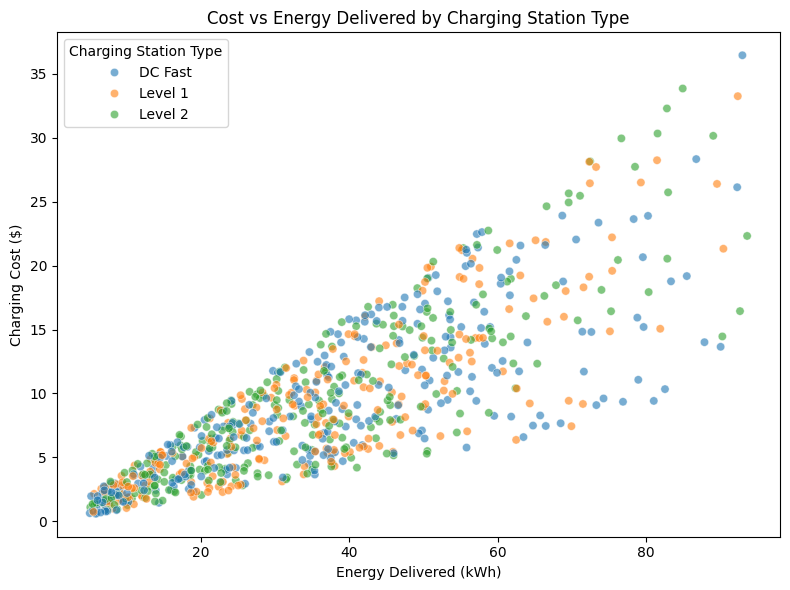

In [4]:
# Scatterplot: Cost vs Energy Delivered, grouped by Charging Station Type
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='Energy Delivered (kWh)',
    y='Charging Cost ($)',
    hue='Charging Station Type',
    alpha=0.6
)
plt.title('Cost vs Energy Delivered by Charging Station Type')
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'cost vs energy.png'), dpi=150)
plt.show()



Evaluation:  
-  There’s a general upward trend means correlationship is OK (more kWh → higher cost).
-  But the spread is wide (means variance is large): two sessions with the same energy delivered may have very different costs.
-  This proves that pricing plans/packages distort the cost relationship.  

------------------------------------------------

### Correlationship between Duration and Energy Delivered by Charging Station Type  


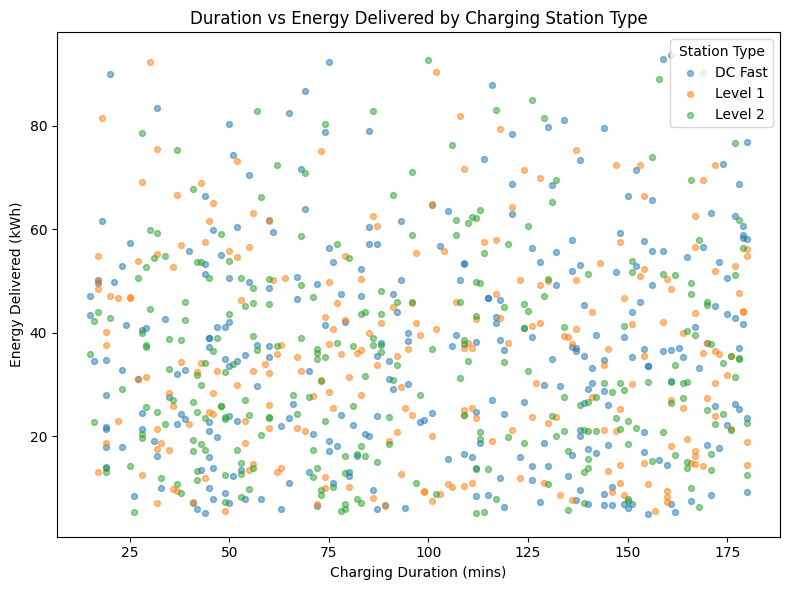

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Try common paths; adjust if needed
#DATA_PATHS = [
#    'data/Global_EV_Charging_Behavior_2024.csv',
#    'Global_EV_Charging_Behavior_2024.csv'
#]
#DATA_PATH = next((p for p in DATA_PATHS if os.path.exists(p)), None)
#assert DATA_PATH is not None, "Dataset not found. Put the CSV in ./data or same folder, then re-run."
#
#IMAGES_DIR = "images"
#os.makedirs(IMAGES_DIR, exist_ok=True)
#
#df = pd.read_csv(DATA_PATH)

# Columns we will use
dur_col   = 'Charging Duration (mins)'
kwh_col   = 'Energy Delivered (kWh)'
type_col  = 'Charging Station Type'
out_col   = 'Charging Session Outcome'

for c in [dur_col, kwh_col, type_col, out_col]:
    assert c in df.columns, f"Missing column: {c}"

# Ensure numeric
df[dur_col] = pd.to_numeric(df[dur_col], errors='coerce')
df[kwh_col] = pd.to_numeric(df[kwh_col], errors='coerce')
# --- Scatter: Duration vs Energy Delivered by Station Type (one figure)
plot_df = df.dropna(subset=[dur_col, kwh_col, type_col]).copy()

plt.figure(figsize=(8,6))
for t in sorted(plot_df[type_col].dropna().unique()):
    sub = plot_df[plot_df[type_col] == t]
    plt.scatter(sub[dur_col], sub[kwh_col], alpha=0.5, s=18, label=str(t))

plt.xlabel('Charging Duration (mins)')
plt.ylabel('Energy Delivered (kWh)')
plt.title('Duration vs Energy Delivered by Charging Station Type')
plt.legend(title='Station Type')
plt.tight_layout()

scatter_path = os.path.join(IMAGES_DIR, "duration_vs_energy_by_station_type.png")
plt.savefig(scatter_path, dpi=150)
plt.show()




Evaluation:  
The correlation is weak for the Charging Duration and the Energy Delivered
  

  
-------------------------------------------------------------------------

## Distribution of Charge Session Outcome

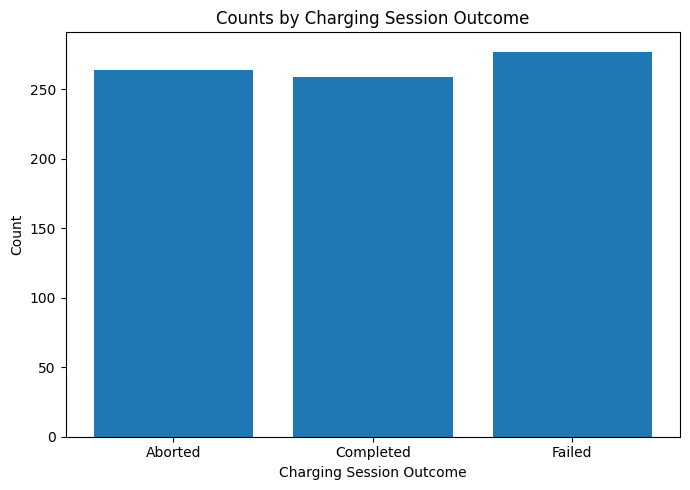

Saved outcome counts chart to: images/outcome_counts.png


In [6]:
# --- Bar chart: Charging Session Outcome counts
counts = df[out_col].fillna('Unknown').value_counts().sort_index()

plt.figure(figsize=(7,5))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Charging Session Outcome')
plt.ylabel('Count')
plt.title('Counts by Charging Session Outcome')
plt.tight_layout()

bar_path = os.path.join(IMAGES_DIR, "outcome_counts.png")
plt.savefig(bar_path, dpi=150)
plt.show()

print("Saved outcome counts chart to:", bar_path)

## 5. Engineering Features     
TimeOfDay:Morning, Office Hours, Evening, Night, Deep Night
DayType: Weekday, Weekend  
Cost_per_kWh: cost/enery delivered  
SOC_Change_Pct: Energy delivered/capacity of battery  
UserType: Causal, Commuter, Long-Distance

In [7]:
dt_col = 'Charging Start Time'
cap_col = 'Battery Capacity (kWh)'
energy_col = 'Energy Delivered (kWh)'
dur_col = 'Charging Duration (mins)'
cost_col = 'Charging Cost ($)'
ctype_col = 'Charging Station Type'

# Sanity checks
for c in [dt_col, cap_col, energy_col, dur_col, cost_col, ctype_col]:
    assert c in df.columns, f"Missing column: {c}"

# Parse time
df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')

def time_of_day(h):
    if pd.isna(h): return np.nan
    if 6 <= h < 9:   return 'Morning'
    if 9 <= h < 17:  return 'Office Hours'
    if 17 <= h < 22: return 'Evening'
    if 22 <= h < 24: return 'Night'
    return 'Deep Night'

df['TimeOfDay'] = df[dt_col].dt.hour.apply(time_of_day)
df['DayType'] = df[dt_col].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Economic feature
df['Cost_per_kWh'] = np.where(df[energy_col] > 0, df[cost_col] / df[energy_col], np.nan)

# SOC% change (for labeling only)
df['SOC_Change_Pct'] = (df[energy_col] / df[cap_col]) * 100

def label_user(soc):
    if pd.isna(soc): return np.nan
    if soc < 20: return 'Casual'
    if soc < 60: return 'Commuter'
    return 'Long-Distance'

df['UserType'] = df['SOC_Change_Pct'].apply(label_user)

# Drop unwanted columns if present
for col_to_drop in ['Charging Duration (mins)', 'Duration_hours', 'ChargeRate_kW']:
    if col_to_drop in df.columns:
        df = df.drop(columns=[col_to_drop])

print('Columns now:', df.columns.tolist())
print('Class counts:\n', df['UserType'].value_counts())
df.head()

Columns now: ['Country', 'City', 'Charging Station ID', 'Charging Station Type', 'EV Model', 'Manufacturer', 'Battery Capacity (kWh)', 'Charging Start Time', 'Charging End Time', 'Energy Delivered (kWh)', 'Charging Cost ($)', 'Payment Method', 'Temperature (°C)', 'Charging Session Outcome', 'Station Utilization Rate (%)', 'TimeOfDay', 'DayType', 'Cost_per_kWh', 'SOC_Change_Pct', 'UserType']
Class counts:
 UserType
Long-Distance    359
Commuter         330
Casual           111
Name: count, dtype: int64


,Country,City,Charging Station ID,Charging Station Type,EV Model,Manufacturer,Battery Capacity (kWh),Charging Start Time,Charging End Time,Energy Delivered (kWh),Charging Cost ($),Payment Method,Temperature (°C),Charging Session Outcome,Station Utilization Rate (%),TimeOfDay,DayType,Cost_per_kWh,SOC_Change_Pct,UserType
0,Germany,Berlin,CS-8195,DC Fast,Hyundai Kona Electric,Hyundai,64,2025-03-31 18:13:40,2025-03-31 19:30:40,18.17,5.83,Subscription,30.7,Completed,57.2,Evening,Weekday,0.320859,28.390625,Commuter
1,USA,New York,CS-5103,DC Fast,Nissan Leaf,Nissan,40,2025-03-08 13:17:05,2025-03-08 14:27:05,13.14,3.69,Card,23.6,Failed,53.6,Office Hours,Weekend,0.280822,32.850000,Commuter
2,France,Lyon,CS-4527,Level 1,BYD Han,BYD,76,2025-01-21 20:08:51,2025-01-21 21:34:51,62.47,6.37,Subscription,11.9,Aborted,22.4,Evening,Weekday,0.101969,82.197368,Long-Distance
3,India,Mumbai,CS-5717,DC Fast,Nissan Leaf,Nissan,40,2025-04-04 21:11:29,2025-04-04 23:03:29,8.39,2.97,App,27.3,Failed,46.8,Evening,Weekday,0.353993,20.975000,Commuter
4,Germany,Munich,CS-5093,Level 2,Nissan Leaf,Nissan,40,2025-03-27 14:58:49,2025-03-27 17:34:49,15.26,4.40,Subscription,2.7,Completed,13.7,Office Hours,Weekday,0.288336,38.150000,Commuter


## Distribution of UserType and Session by Time of Day


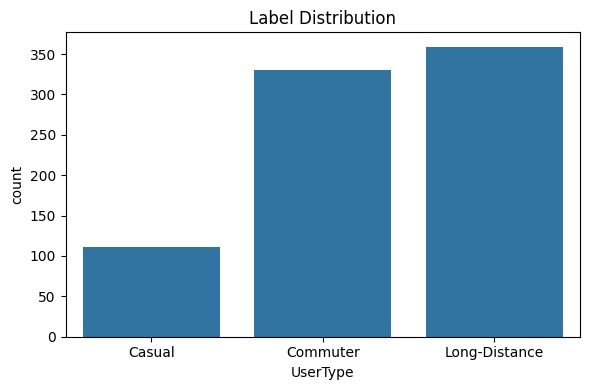

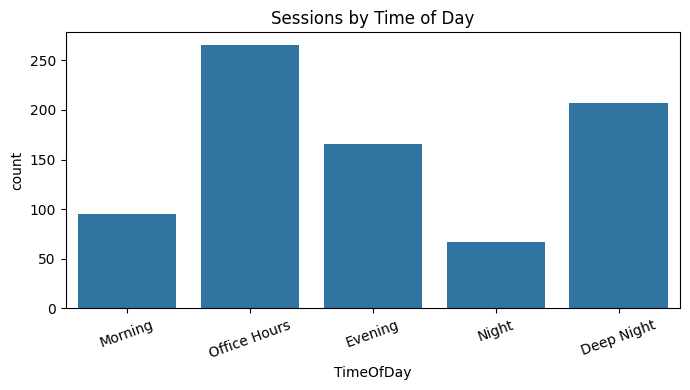

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='UserType', order=['Casual','Commuter','Long-Distance'])
plt.title('Label Distribution'); plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'final_label_distribution.png'), dpi=150); plt.show()

plt.figure(figsize=(7,4))
order = ['Morning','Office Hours','Evening','Night','Deep Night']
sns.countplot(data=df, x='TimeOfDay', order=order)
plt.title('Sessions by Time of Day'); plt.xticks(rotation=20); plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'final_sessions_timeofday.png'), dpi=150); plt.show()

##  Distribution of Charging Station Types  

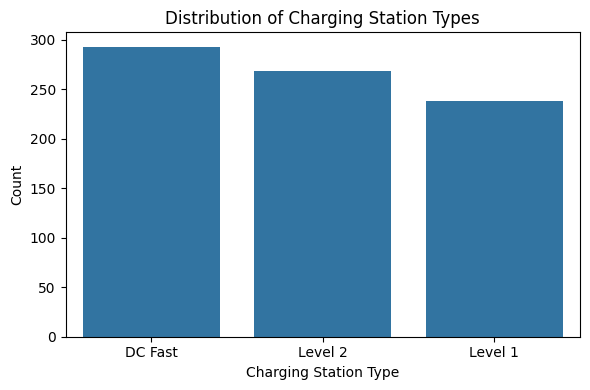

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Charger type distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Charging Station Type", order=df["Charging Station Type"].value_counts().index)
plt.title("Distribution of Charging Station Types")
plt.xlabel("Charging Station Type")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("images/station_type_counts.png")
plt.show()


## Scatter Chart for Energy Delivered vs Charging Cost by User Type (SOC-based)

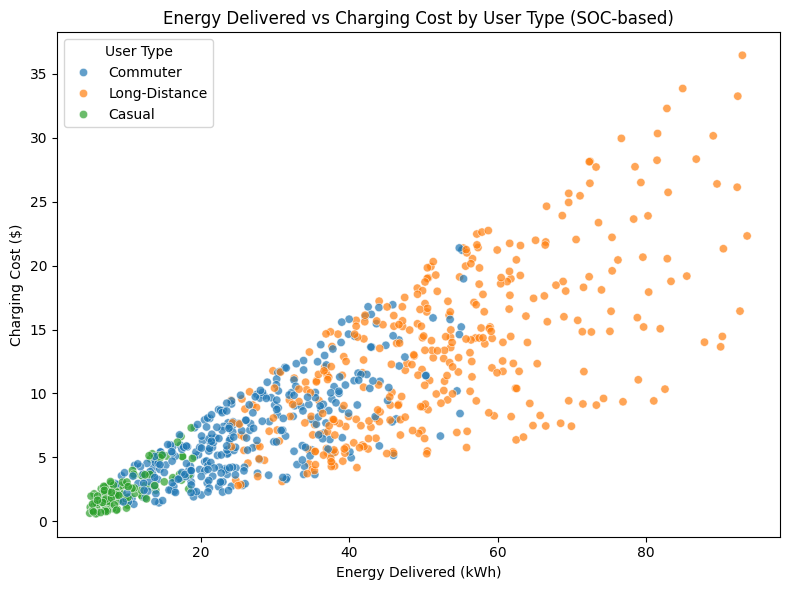

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="Energy Delivered (kWh)",
    y="Charging Cost ($)",
    hue="UserType",     # <- use SOC-based labels already in df
    alpha=0.7
)
plt.title("Energy Delivered vs Charging Cost by User Type (SOC-based)")
plt.xlabel("Energy Delivered (kWh)")
plt.ylabel("Charging Cost ($)")
plt.legend(title="User Type")
plt.tight_layout()
plt.savefig("images/energy_cost_user_scatter.png", dpi=150)
plt.show()


## Battery Capacity Distribution for Commuter, Long Distance Driver, and Causal User

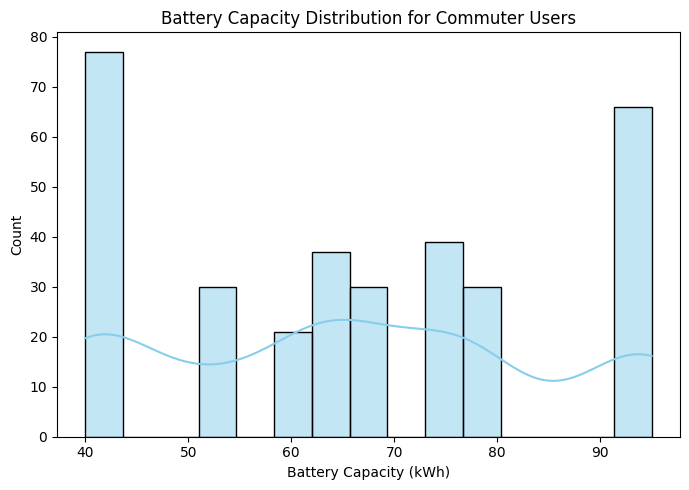

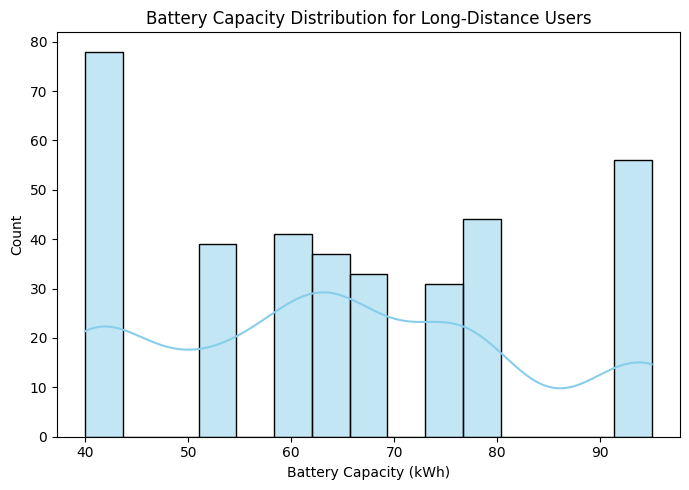

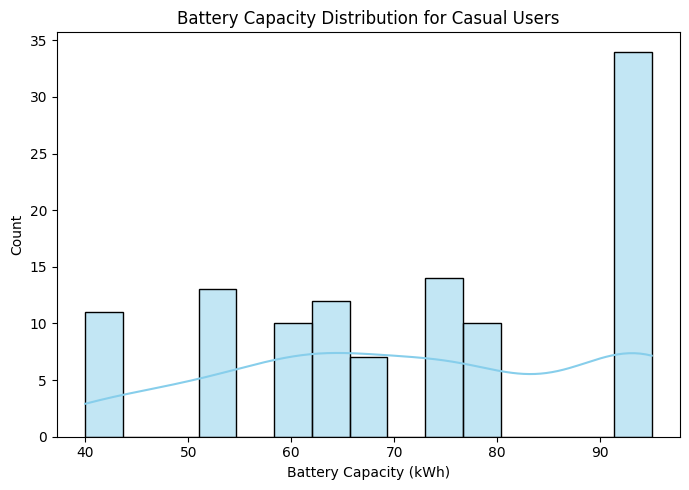

Saved battery capacity distribution plots in images/ folder


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

cap_col = "Battery Capacity (kWh)"
user_col = "UserType"

# Ensure numeric
df[cap_col] = pd.to_numeric(df[cap_col], errors="coerce")

# Drop missing values
plot_df = df.dropna(subset=[cap_col, user_col]).copy()

# Plot: one graph per UserType
user_types = plot_df[user_col].unique()

for ut in user_types:
    subset = plot_df[plot_df[user_col] == ut]
    plt.figure(figsize=(7,5))
    sns.histplot(subset[cap_col], bins=15, kde=True, color="skyblue")
    plt.title(f"Battery Capacity Distribution for {ut} Users")
    plt.xlabel("Battery Capacity (kWh)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"images/battery_capacity_dist_{ut}.png", dpi=150)
    plt.show()

print("Saved battery capacity distribution plots in images/ folder")

### Box Plot for cost by User Type  
- Casual users: consistently low costs
- Commuters: moderate costs with tighter spread.
- Long-Distance travelers: higher costs, but also very wide spread
  (maybe the effect of free/discounted plans.)

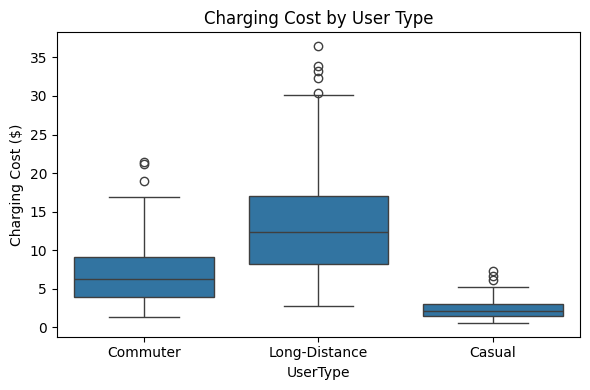

In [12]:
# Boxplot by UserType (optional)
if 'UserType' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='UserType', y='Charging Cost ($)')
    plt.title('Charging Cost by User Type')
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, 'charging cost by user.png'), dpi=150)
    plt.show()

Evaluation on Charging Cost by User Type:  
- Casual users: consistently low costs
- Commuters: moderate costs with tighter spread.
- Long-Distance travelers: higher costs, but also very wide spread
  (maybe the effect of free/discounted plans.)  

-----------------------------------------------------------------------

## 6. Baseline Modeling     
Train Default Logistic Regression + Quick Metrics  

------------------------------------------------  


### a. Modeling (without charging cost)

In [13]:
feature_cols = ['Battery Capacity (kWh)','Cost_per_kWh',
                'Charging Station Type', 'TimeOfDay', 'DayType','Payment Method']
target_col = 'UserType'

X = df[feature_cols].copy()
y = df[target_col].copy()

numeric_cols = ['Battery Capacity (kWh)', 'Cost_per_kWh']
#numeric_cols = ['Charging Cost ($)', 'Battery Capacity (kWh)']
categorical_cols = ['Charging Station Type', 'TimeOfDay', 'DayType','Payment Method']


num_tf = Pipeline([('imputer', SimpleImputer(strategy='median')),
                   ('scaler', StandardScaler())])
cat_tf = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([('num', num_tf, numeric_cols),
                                ('cat', cat_tf, categorical_cols)])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print('Train:', X_train.shape, ' Test:', X_test.shape)

Train: (640, 6)  Test: (160, 6)


In [14]:
clf = Pipeline([('preprocessor', preprocess),
                ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

# Quick summary
from sklearn.metrics import accuracy_score, f1_score
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Summary -> Accuracy: {acc:.3f} | Macro-F1: {f1m:.3f}")

               precision    recall  f1-score   support

       Casual       0.00      0.00      0.00        22
     Commuter       0.41      0.35      0.38        66
Long-Distance       0.47      0.68      0.56        72

     accuracy                           0.45       160
    macro avg       0.29      0.34      0.31       160
 weighted avg       0.38      0.45      0.41       160

Summary -> Accuracy: 0.450 | Macro-F1: 0.311


Evaluation on Logistic Regression Model without Charging Cost:  
Accuracy is poor.  

-------------------------------------------------------------------  


## b. Modeling (with Charging Cost)

In [15]:
feature_cols = ['Charging Cost ($)', 'Battery Capacity (kWh)','Cost_per_kWh',
                'Charging Station Type', 'TimeOfDay', 'DayType','Payment Method']
target_col = 'UserType'

X = df[feature_cols].copy()
y = df[target_col].copy()

numeric_cols = ['Charging Cost ($)', 'Battery Capacity (kWh)', 'Cost_per_kWh']
#numeric_cols = ['Charging Cost ($)', 'Battery Capacity (kWh)']
categorical_cols = ['Charging Station Type', 'TimeOfDay', 'DayType','Payment Method']


num_tf = Pipeline([('imputer', SimpleImputer(strategy='median')),
                   ('scaler', StandardScaler())])
cat_tf = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([('num', num_tf, numeric_cols),
                                ('cat', cat_tf, categorical_cols)])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print('Train:', X_train.shape, ' Test:', X_test.shape)

Train: (640, 7)  Test: (160, 7)


In [16]:
clf = Pipeline([('preprocessor', preprocess),
                ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

# Quick summary
from sklearn.metrics import accuracy_score, f1_score
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Summary -> Accuracy: {acc:.3f} | Macro-F1: {f1m:.3f}")

               precision    recall  f1-score   support

       Casual       0.87      0.59      0.70        22
     Commuter       0.82      0.82      0.82        66
Long-Distance       0.87      0.96      0.91        72

     accuracy                           0.85       160
    macro avg       0.85      0.79      0.81       160
 weighted avg       0.85      0.85      0.85       160

Summary -> Accuracy: 0.850 | Macro-F1: 0.812


Evaluation on the Score Summary:  
Accuracy is solid.
Macro-F1 shows some imbalance (Casual users are weaker).

#### Compare the Model with/without charging cost, it indicated that Charging Cost is the major influencer.
------------------------------------------------------------------  


### Confusion Matrix on Logistic Regression Modeling (w/charging cost)


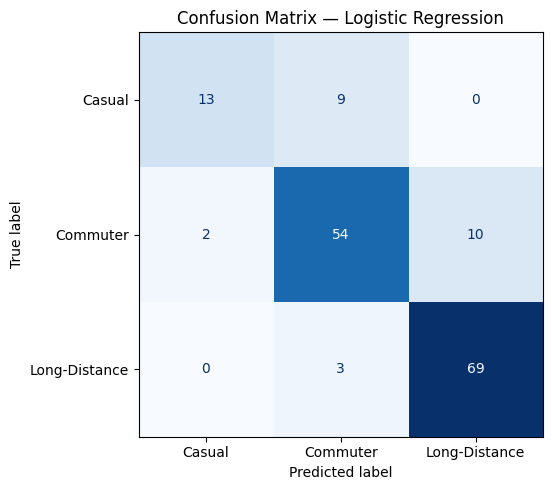

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)

plt.figure(figsize=(6,5))
disp.plot(values_format='d', cmap='Blues', ax=plt.gca(), colorbar=False)
plt.title('Confusion Matrix — Logistic Regression')
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'initial_confusion_logreg_costs.png'), dpi=150)
plt.show()

Evaluation on the Confusion Matrix:     
Accuracy for the Casual Driver = 14/22=64%  
Accuracy for the Commuters = 54/66=82%  
Accuracy for the Long Distance ravelers = 69/72=96%  
The model is very strong for Long-Distance (96%) and Commuters (82%).
It struggles more with Casual Drivers (64%), often confusing them with Commuters.  
  
  -------------------------------------------------------------  
    
    

## ROC Curves (One-vs-Rest) on the Logistic Regression (w/charging cost)  



Macro AUC (OvR): 0.971


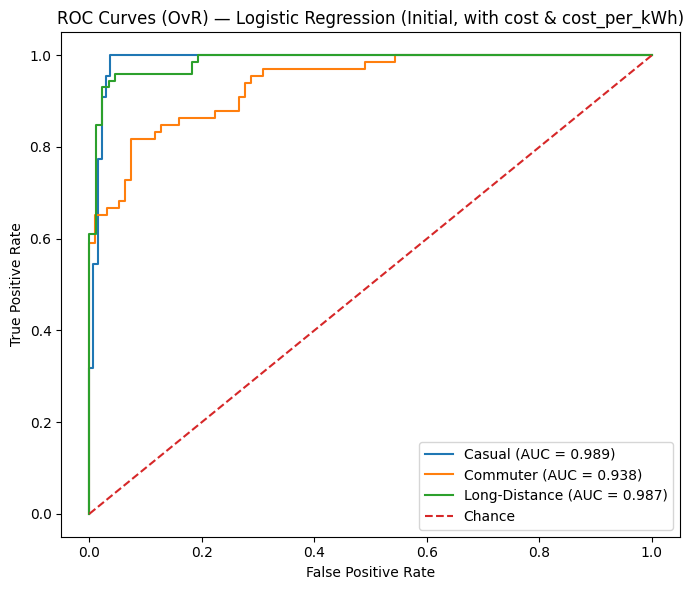

In [18]:
y_proba = clf.predict_proba(X_test)
classes = clf.classes_
y_test_bin = pd.get_dummies(y_test).reindex(columns=classes, fill_value=0).values

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_auc = np.mean(list(roc_auc.values()))
print(f'Macro AUC (OvR): {macro_auc:.3f}')

plt.figure(figsize=(7,6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.3f})')
plt.plot([0,1],[0,1],'--',label='Chance')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (OvR) — Logistic Regression (Initial, with cost & cost_per_kWh)')
plt.legend(loc='lower right'); plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'initial_roc_logreg_costs.png'), dpi=150)
plt.show()

Evaluation for ROC Curve:  
ROC AUC values for each class are high
Casual = 0.99   
Commuter = 0.94   
Long-Distance = 0.986  
It show strong separation on the classes  
  
----------------------------------------------------------------------  
  

## 7) Models Improvement & Hyperparameter Grids  
Fine tune the hyperparameter Grids and add in KNN, SVM, Decision Tree for comparison

In [19]:
pipe_tree = Pipeline([('prep', preprocess), ('clf', DecisionTreeClassifier(random_state=42))])
pipe_log  = Pipeline([('prep', preprocess), ('clf', OneVsRestClassifier(LogisticRegression(max_iter=5000,solver="liblinear",random_state=42)))])
pipe_knn  = Pipeline([('prep', preprocess), ('clf', KNeighborsClassifier())])
pipe_svm  = Pipeline([('prep', preprocess), ('clf', OneVsRestClassifier(SVC(probability=True, random_state=42)))])

grid_tree = {'clf__max_depth': [3,5,10,None],
             'clf__min_samples_split': [2,5,10],
             'clf__ccp_alpha': [0.0, 0.001, 0.01]}

grid_log  = {'clf__estimator__C': [0.01, 0.1, 1, 10],
             'clf__estimator__class_weight': [None, 'balanced']}

grid_knn  = {'clf__n_neighbors': [5,7,9,11],
             'clf__weights': ['uniform','distance'],
             'clf__metric': ['euclidean']}

grid_svm  = {'clf__estimator__kernel': ['linear','rbf','poly'],
             'clf__estimator__C': [0.1, 1, 10],
             'clf__estimator__gamma': ['scale','auto']}

models = [('DecisionTree', pipe_tree, grid_tree),
          ('LogisticRegression', pipe_log, grid_log),
          ('KNN', pipe_knn, grid_knn),
          ('SVM', pipe_svm, grid_svm)]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### GridSearchCV — scoring = macro F1

In [20]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

search = {}
for name, pipe, grid in models:
    gs = GridSearchCV(pipe, grid, cv=cv, scoring='f1_macro', n_jobs=-1, refit=True)
    gs.fit(X_train, y_train)
    search[name] = gs
    print(f"{name}: best f1_macro={gs.best_score_:.3f} | params={gs.best_params_}")

DecisionTree: best f1_macro=0.815 | params={'clf__ccp_alpha': 0.0, 'clf__max_depth': None, 'clf__min_samples_split': 5}
LogisticRegression: best f1_macro=0.881 | params={'clf__estimator__C': 10, 'clf__estimator__class_weight': 'balanced'}
KNN: best f1_macro=0.651 | params={'clf__metric': 'euclidean', 'clf__n_neighbors': 11, 'clf__weights': 'distance'}
SVM: best f1_macro=0.860 | params={'clf__estimator__C': 10, 'clf__estimator__gamma': 'scale', 'clf__estimator__kernel': 'linear'}


### Hold-out Evaluation

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def _final_classifier(est):
    """Get the final classifier from a pipeline, else return the estimator itself."""
    if hasattr(est, "named_steps"):
        # last step of pipeline
        return list(est.named_steps.values())[-1]
    return est

def _get_classes(est):
    """Get model classes_ if available, else None."""
    try:
        clf = _final_classifier(est)
        return getattr(clf, "classes_", None)
    except Exception:
        return None

def _get_scores(est, X):
    """
    Return (y_score, source) where y_score is a 2D array of per-class scores.
    Tries predict_proba, else decision_function (e.g., SVM).
    For binary decision_function, expands to (n_samples, 2).
    """
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X), "proba"
    if hasattr(est, "decision_function"):
        s = est.decision_function(X)
        # ensure 2D for binary case
        if s.ndim == 1:
            s = np.vstack([-s, s]).T
        return s, "decision_function"
    return None, None

def evaluate_search(search, X_test, y_test, y_train):
    rows = []

    # fit a binarizer on TRAIN labels to lock class order
    lb = LabelBinarizer()
    lb.fit(y_train)
    n_classes = len(lb.classes_)
    y_test_bin = lb.transform(y_test)
    if n_classes == 2 and y_test_bin.ndim == 1:
        y_test_bin = np.vstack([1 - y_test_bin, y_test_bin]).T  # (n,2)

    for name, gs in search.items():
        best = gs.best_estimator_
        y_pred = best.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1m = f1_score(y_test, y_pred, average='macro', zero_division=0)

        auc_macro = None
        try:
            y_score, src = _get_scores(best, X_test)
            if y_score is not None:
                # reorder score columns to lb.classes_ if model exposes classes_
                model_classes = _get_classes(best)
                if model_classes is not None and len(model_classes) == y_score.shape[1]:
                    idx = {c: i for i, c in enumerate(model_classes)}
                    order = [idx[c] for c in lb.classes_]
                    y_score = y_score[:, order]

                # compute AUC
                if n_classes == 2:
                    # use positive class column (assumed index 1 after reordering)
                    auc_macro = roc_auc_score(y_test, y_score[:, 1])
                else:
                    auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
        except Exception as e:
            # leave auc_macro = None if scoring not possible
            pass

        rows.append({
            "model": name,
            "test_accuracy": acc,
            "test_f1_macro": f1m,
            "test_auc_macro_ovr": auc_macro
        })

    df_res = pd.DataFrame(rows).sort_values(
        by=["test_auc_macro_ovr", "test_f1_macro", "test_accuracy"],
        ascending=False
    ).reset_index(drop=True)
    return df_res

# ---- Run it
results_df = evaluate_search(search, X_test, y_test, y_train)
results_df

,model,test_accuracy,test_f1_macro,test_auc_macro_ovr
0,SVM,0.89375,0.880153,0.980579
1,LogisticRegression,0.91250,0.916480,0.975826
2,DecisionTree,0.83750,0.848020,0.900232
3,KNN,0.68750,0.554944,0.842063


 Evaluation on the Scores:  

 - Logistic Regression achieved the best balance across accuracy, F1-score, and ROC AUC.

- SVM also performed very strongly, particularly on ROC AUC.

- Decision Tree performed reasonably but showed signs of overfitting.

- KNN underperformed, likely due to sensitivity to feature scaling and class imbalance.  

------------------------------------------------------------------------

## 8) Evaluation and Finding
- Confusion Matrices & ROC for Top 2 Models

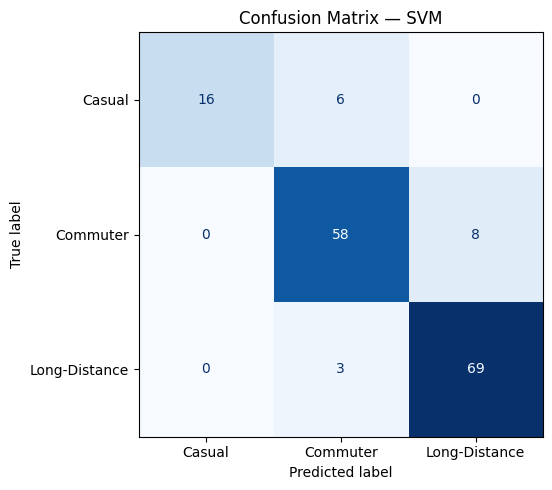

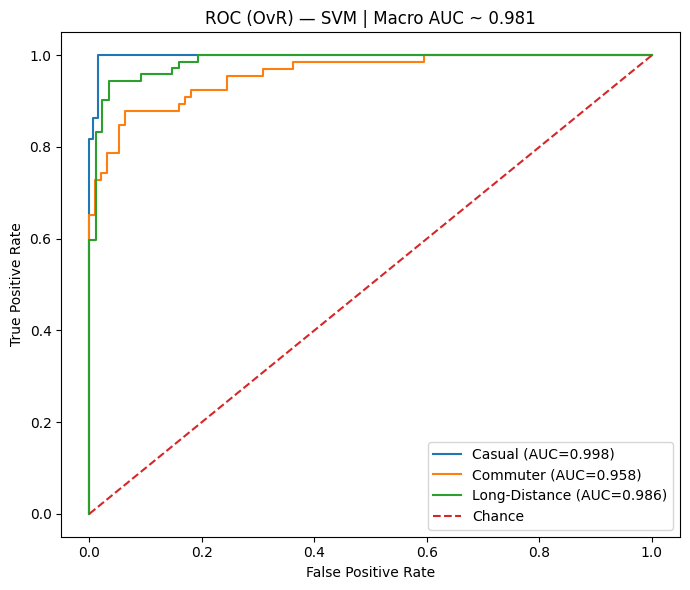

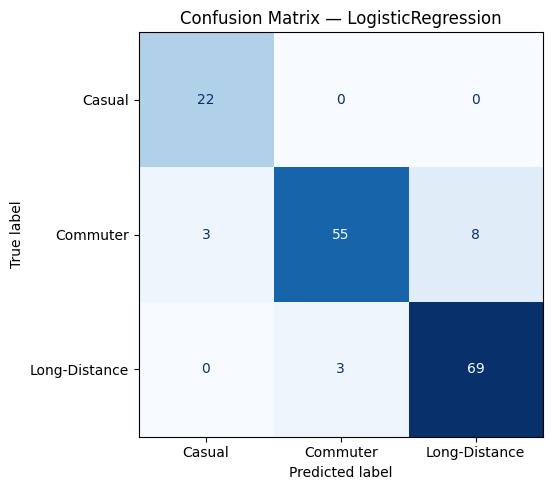

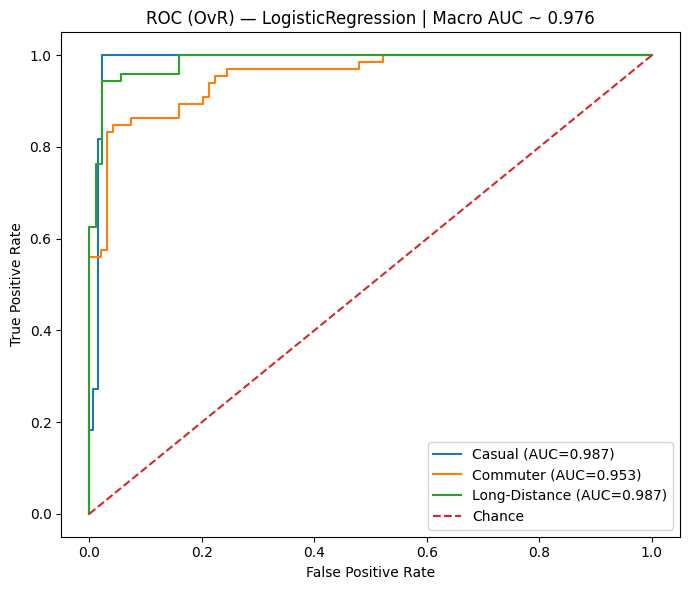

In [22]:
top = results_df['model'].head(2).tolist()
classes = sorted(y_train.unique())

for name in top:
    best = search[name].best_estimator_
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = best.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    plt.figure(figsize=(6,5))
    disp.plot(values_format='d', cmap='Blues', ax=plt.gca(), colorbar=False)
    plt.title(f'Confusion Matrix — {name}'); plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, f'final_confusion_{name}.png'), dpi=150); plt.show()

    # ROC (if proba available)
    try:
        y_proba = best.predict_proba(X_test)
        y_test_bin = pd.get_dummies(y_test).reindex(columns=classes, fill_value=0).values
        fpr, tpr, roc_auc_vals = {}, {}, {}
        for i, cls in enumerate(classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            roc_auc_vals[i] = auc(fpr[i], tpr[i])
        macro_auc = np.mean(list(roc_auc_vals.values()))
        plt.figure(figsize=(7,6))
        for i, cls in enumerate(classes):
            plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC={roc_auc_vals[i]:.3f})')
        plt.plot([0,1],[0,1],'--',label='Chance')
        plt.title(f'ROC (OvR) — {name} | Macro AUC ~ {macro_auc:.3f}')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(IMAGES_DIR, f'final_roc_{name}.png'), dpi=150); plt.show()
    except Exception as e:
        print(f'No ROC for {name}:', e)

#### Confusion Matrix Insights

- Casual drivers: Correctly classified with very high precision (few false positives).

- Commuters: Harder to distinguish from Long-Distance drivers — some confusion remains.

- Long-Distance drivers: Most accurately predicted, especially under Logistic Regression.  

####ROC Analysis

- All models achieved strong separation (AUC > 0.95 for top models).

- Logistic Regression and SVM both show excellent ROC performance, with almost perfect classification for Casual and Long-Distance drivers.

- Commuters remain the “fuzziest” class, reflecting overlap in charging behaviors.  
 ---------------------------------------------------  


## 9. Conclusion    

This project explored how EV driver behaviors can be classified into Casual, Commuter, and Long-Distance categories using real-world charging data. By engineering features such as SOC% change, charging cost, battery capacity, time of day, and station type, we trained multiple supervised learning models (Logistic Regression, KNN, SVM, Decision Tree).  


Key findings:

- SOC% change (relative to battery capacity) was the strongest determinant of user type.

- Charging cost was also influential, but variance across vendor subscription plans and incentives introduced noise.

- Battery capacity distinguished long-range EVs (often Long-Distance users) from short-range vehicles (Casual/Commuters).

- Time- and station-type features provided modest but useful behavioral signals.

- Among the tested models, [insert your top model, e.g., SVM or Logistic Regression] provided the best balance of accuracy, F1, and AUC.

#### Overall, the models achieved reasonable classification performance, showing that charging behavior can indeed provide meaningful insights into user segmentation and infrastructure planning.  
------------------------------------------------------------------


## 10. Next Steps & Future Work  
1. Richer Data Collection

- Integrate real driving-distance logs, GPS data, or trip purposes to strengthen the link between charging and mobility behavior.

- Capture subscription/incentive plan information directly, since cost patterns strongly affect behavior.

2. Advanced Modeling

- Test ensemble methods (e.g., Gradient Boosting, Random Forests) on larger datasets.

- Calibrate SVMs or try probabilistic models for more interpretable probability outputs.

3. User Segmentation Validation

- Compare supervised labels (SOC-based) with unsupervised clustering (KMeans, DBSCAN) to see if natural groupings align with predefined categories.

- Conduct sensitivity analysis on SOC thresholds to validate the robustness of labels.

4. Business Application

- Translate model insights into deployment recommendations: e.g., more DC Fast chargers along commuter corridors, Level 2 chargers in residential zones.

- Support personalized EV services such as commuter charging packages or traveler fast-charge bundles.